In [1]:
import numpy as np
import pandas as pd
import open3d
import os
import tqdm
import matplotlib.pyplot as plt
import utils.helpers as helpers
import utils.fread as fread
import utils.registration as registration
import copy

from utils.depth_camera import DepthCamera
from utils.config import Config

import utils.registration as registration
import utils.fread as fread
import utils.FCGF as FCGF
import utils.helpers as helpers

from scipy import signal
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
config = Config(
    sequence_dir="data/raw_data",
    feature_dir="data/features",
    output_dir="data/trajectories/estimated_imu+depth",
    experiment="exp_8",
    trial="trial_2",
    subject="subject-1",
    sequence="02",
    groundtruth_dir="data/trajectories/groundtruth",
    voxel_size=0.03
)

In [3]:
pose_file = os.path.join(config.get_groundtruth_dir(), f"{config.get_file_name()}.pose.npz")
motion_dir = config.get_motion_dir(include_secondary=False)

In [4]:
accel_df = pd.read_csv(os.path.join(motion_dir, "accel.csv"))
gyro_df = pd.read_csv(os.path.join(motion_dir, "gyro.csv"))

accel_df.drop_duplicates("timestamp", inplace=True)
gyro_df.drop_duplicates("timestamp", inplace=True)

gravity_df = pd.DataFrame(columns=["timestamp", "x", "y", "z"])

imu_df = pd.merge(accel_df, gyro_df, on="timestamp", suffixes=("a", "g"))

raw_accel_df = imu_df[["timestamp", "xa", "ya", "za"]].copy()

frame_rate = accel_df.shape[0] / (accel_df.timestamp.values[-1] - accel_df.timestamp.values[0]) * 1000

# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

print(f"Frame rate: {frame_rate:.2f} Hz")

Frame rate: 400.91 Hz


In [72]:
# # apply gaussian filter to smooth acceleration and gyro data
# imu_df.loc[:, "xa"] = gaussian_filter1d(imu_df.xa.values, sigma=10)
# imu_df.loc[:, "ya"] = gaussian_filter1d(imu_df.ya.values, sigma=10)
# imu_df.loc[:, "za"] = gaussian_filter1d(imu_df.za.values, sigma=10)
# imu_df.loc[:, "xg"] = gaussian_filter1d(imu_df.xg.values, sigma=10)
# imu_df.loc[:, "yg"] = gaussian_filter1d(imu_df.yg.values, sigma=10)
# imu_df.loc[:, "zg"] = gaussian_filter1d(imu_df.zg.values, sigma=10)

In [5]:
win_len = int(frame_rate * 4) # 4 seconds window
gravity = imu_df.iloc[:win_len, [1, 2, 3]].mean().values

In [6]:
imu_df[["xa", "ya", "za"]] = imu_df[["xa", "ya", "za"]] - gravity
    
accel_mavg = imu_df[["xa", "ya", "za"]].rolling(window=win_len).mean()
accel_mavg.fillna(0, inplace=True)

imu_df[["xa", "ya", "za"]] = imu_df[["xa", "ya", "za"]] - accel_mavg

imu_df = imu_df.iloc[win_len:]

In [5]:
# calculate displacement and rotation
imu_df.iloc[0, 8:11] = [0, 0, 0]

rotation_matrix = np.identity(4)
velocity = [0, 0, 0]

for i in tqdm.trange(1, len(imu_df)):
    v = imu_df.iloc[i].values
    dt = v[7]
    
    # current displacement and rotation
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
    
    acceleration = imu_df.iloc[i, [1, 2, 3]].values

    d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
    d = np.dot(rotation_matrix, np.array([*d, 1]))
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]

100%|██████████| 8017/8017 [00:04<00:00, 1941.81it/s]


In [6]:
estimated_trajectory = helpers.make_pcd(imu_df.loc[:, ["x", "y", "z"]].values)
estimated_trajectory.paint_uniform_color([1, 0, 0])

PointCloud with 8018 points.

In [7]:
depth_camera = DepthCamera("secondary", os.path.join(config.sequence_dir, config.experiment, "metadata", "device-0-aligned.json"))

In [8]:
sequence_ts = fread.get_timstamps_from_images(config.get_sequence_dir(include_secondary=False), ext=".depth.png")

poses = np.load(pose_file)
trajectory_t = poses["trajectory_t"]
local_t = poses["local_t"]

start_ind = 30 * 5
# start_t = helpers.nearest(sequence_ts, imu_df.timestamp.values[0])
# start_ind = np.where(sequence_ts == start_t)[0][0]
sequence_ts = sequence_ts[start_ind:]
trajectory_t = trajectory_t[start_ind:]

In [9]:
local_pcds = []

for t in tqdm.trange(len(sequence_ts)):
    depth_img_file = os.path.join(config.get_sequence_dir(include_secondary=False), f"frame-{sequence_ts[t]}.depth.png")
    pcd = depth_camera.depth_to_point_cloud(depth_img_file)
    pcd = pcd.voxel_down_sample(voxel_size=config.voxel_size)
    local_pcds.append(pcd)

100%|██████████| 340/340 [00:13<00:00, 25.95it/s]


In [10]:
trajectory_pcd = []

for t in range(len(sequence_ts)):
    local_pcd_copy = copy.deepcopy(local_pcds[t])
    local_pcd_copy.transform(trajectory_t[t])
    trajectory_pcd.append(local_pcd_copy)
    
trajectory_pcd = helpers.merge_pcds(trajectory_pcd, config.voxel_size)

# open3d.visualization.draw_geometries([trajectory_pcd])

In [45]:
gt_xyz = trajectory_t[start_ind:, :3, 3]
gt_trajectory = helpers.make_pcd(gt_xyz)
gt_trajectory.paint_uniform_color([0, 1, 0])

PointCloud with 340 points.

In [84]:
print("GT Distance: ", np.linalg.norm(gt_xyz[-1] - gt_xyz[0]))
print("Estimated Distance: ", np.linalg.norm(imu_df.loc[:, ["x", "y", "z"]].values[-1] - imu_df.loc[:, ["x", "y", "z"]].values[0]))

GT Distance:  9.810121353637658
Estimated Distance:  11.456394298696024


In [78]:
open3d.visualization.draw_geometries([gt_trajectory, estimated_trajectory])

In [317]:
elapsed_time = np.array((sequence_ts - sequence_ts[0]) // 1e3, dtype=np.int32)
# calibration_ts = np.argwhere(elapsed_time == 0).flatten()

In [318]:
pcd_reg_time = 1 # seconds
imu_reg_time = 2 # seconds

In [319]:
template = np.array([[0] * pcd_reg_time + [1] * imu_reg_time])
duration = np.ceil(elapsed_time[-1] / (pcd_reg_time + imu_reg_time)).astype(np.int16) + 1
mapping = np.repeat(template, duration, axis=0).flatten()
pattern = mapping[np.expand_dims(elapsed_time.astype(np.int16), axis=1)].flatten()

In [320]:
pcd_start_ids = np.arange(duration) * (pcd_reg_time + imu_reg_time)
imu_start_ids = pcd_start_ids + pcd_reg_time

In [321]:
pcd_inds = np.concatenate([np.expand_dims(pcd_start_ids, axis=1), np.expand_dims(imu_start_ids, axis=1)], axis=1)
imu_inds = np.concatenate([np.expand_dims(imu_start_ids[:-1], axis=1), np.expand_dims(pcd_start_ids[1:], axis=1)], axis=1)

inds = np.concatenate([pcd_inds[:-1], imu_inds], axis=1)

In [322]:
# find first indices of each second
elapsed_time_inds = np.argwhere(np.diff(elapsed_time)).flatten() + 1
# add zero to the beginning
elapsed_time_inds = np.concatenate([[0], elapsed_time_inds])

In [327]:
start_pcd_t, end_pcd_t, start_imu_t, end_imu_t = inds[0]

In [328]:
calibration_ts = np.arange(elapsed_time_inds[start_pcd_t], elapsed_time_inds[end_pcd_t])
imu_sequence_ts = np.arange(elapsed_time_inds[start_imu_t], elapsed_time_inds[end_imu_t])

In [329]:
# velocity
velocities = np.diff(gt_xyz[calibration_ts], axis=0) * 1e3 / np.diff(sequence_ts[calibration_ts]).reshape(-1, 1)
linear_acceleration = np.diff(velocities, axis=0) * 1e3 / np.diff(sequence_ts[calibration_ts][1:]).reshape(-1, 1)

In [330]:
calibration_imu_df = imu_df[(imu_df.timestamp >= sequence_ts[calibration_ts[2]]) & (imu_df.timestamp <= sequence_ts[calibration_ts[-1]])].copy()

In [331]:
rotation_matrices = trajectory_t[start_ind:, :3, :3][calibration_ts]

euler_angles = np.array([helpers.rotation_matrix_to_euler_angles(R) for R in rotation_matrices])
angular_velocity = np.diff(euler_angles, axis=0) * 1e3 / np.diff(sequence_ts[calibration_ts]).reshape(-1, 1)

resampled_angular_velocity = []
resampled_angular_velocity.append(interpolate.interp1d(sequence_ts[calibration_ts][1:], angular_velocity[:, 0], kind="cubic")(calibration_imu_df.timestamp.values))
resampled_angular_velocity.append(interpolate.interp1d(sequence_ts[calibration_ts][1:], angular_velocity[:, 1], kind="cubic")(calibration_imu_df.timestamp.values))
resampled_angular_velocity.append(interpolate.interp1d(sequence_ts[calibration_ts][1:], angular_velocity[:, 2], kind="cubic")(calibration_imu_df.timestamp.values))

resampled_angular_velocity = np.array(resampled_angular_velocity).T

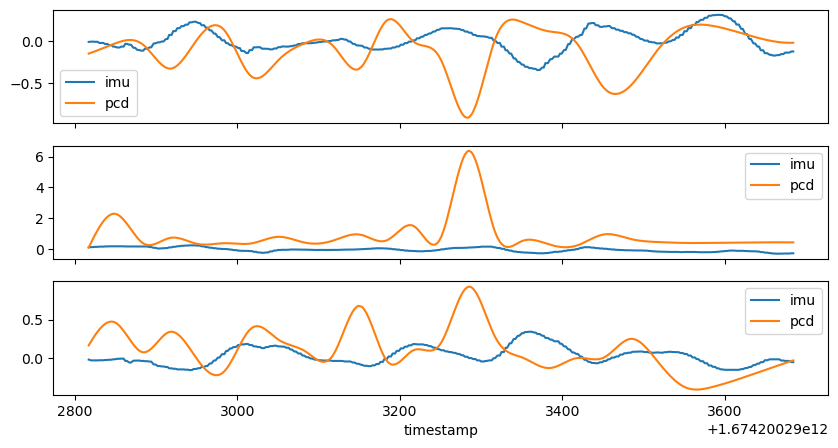

In [332]:
fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

calibration_imu_df.plot(x="timestamp", y="xg", ax=axs[0], label="imu")
axs[0].plot(calibration_imu_df.timestamp.values, resampled_angular_velocity[:, 0], label="pcd")
axs[0].legend()

calibration_imu_df.plot(x="timestamp", y="yg", ax=axs[1], label="imu")
axs[1].plot(calibration_imu_df.timestamp.values, resampled_angular_velocity[:, 1], label="pcd")
axs[1].legend()

calibration_imu_df.plot(x="timestamp", y="zg", ax=axs[2], label="imu")
axs[2].plot(calibration_imu_df.timestamp.values, resampled_angular_velocity[:, 2], label="pcd")
axs[2].legend()

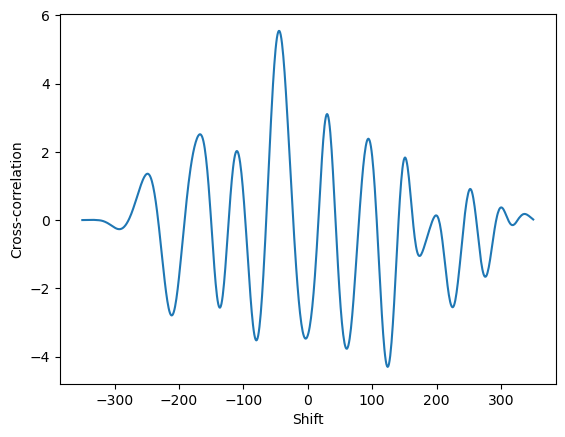

In [333]:
corr = np.correlate(calibration_imu_df.xg.values, resampled_angular_velocity[:, 0], mode='full')
shifts = np.arange(-calibration_imu_df.shape[0] + 1, calibration_imu_df.shape[0])  # All possible shifts

plt.plot(shifts, corr)
plt.xlabel('Shift')
plt.ylabel('Cross-correlation')
plt.show()

In [334]:
delta = (np.argmax(corr) - calibration_imu_df.shape[0] + 1) * 1000 / frame_rate
print(f"Time shift: {delta} ms")

Time shift: -112.24466891133558 ms


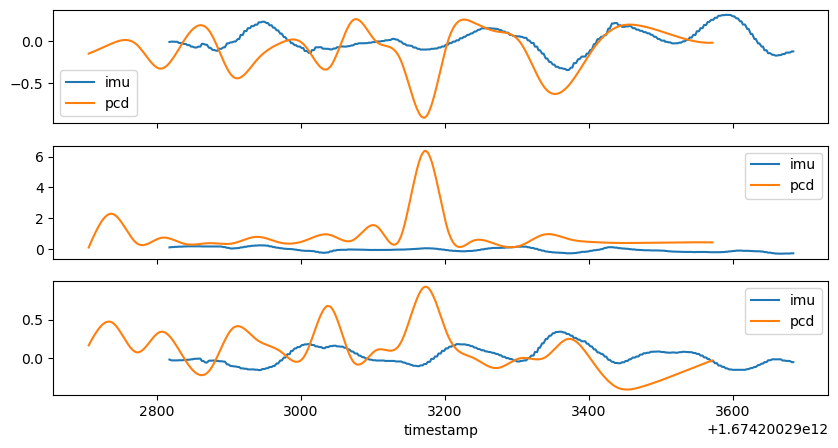

In [335]:
fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

calibration_imu_df.plot(x="timestamp", y="xg", ax=axs[0], label="imu")
axs[0].plot(calibration_imu_df.timestamp.values + delta, resampled_angular_velocity[:, 0], label="pcd")
axs[0].legend()

calibration_imu_df.plot(x="timestamp", y="yg", ax=axs[1], label="imu")
axs[1].plot(calibration_imu_df.timestamp.values + delta, resampled_angular_velocity[:, 1], label="pcd")
axs[1].legend()

calibration_imu_df.plot(x="timestamp", y="zg", ax=axs[2], label="imu")
axs[2].plot(calibration_imu_df.timestamp.values + delta, resampled_angular_velocity[:, 2], label="pcd")
axs[2].legend()

In [290]:
gyro_bias = resampled_angular_velocity.mean(axis=0) - calibration_imu_df.loc[:, ["xg", "yg", "zg"]].values.mean(axis=0)

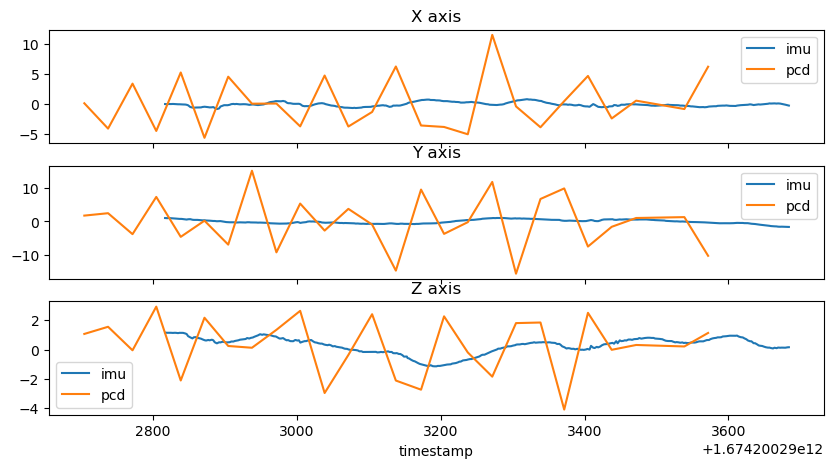

In [208]:
fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

calibration_imu_df.plot(x="timestamp", y="xa", ax=axs[0], label="imu")
axs[0].plot(sequence_ts[calibration_ts][2:] + delta, linear_acceleration[:, 0], label="pcd")
axs[0].set_title("X axis")
axs[0].legend()

calibration_imu_df.plot(x="timestamp", y="ya", ax=axs[1], label="imu")
axs[1].plot(sequence_ts[calibration_ts][2:] + delta, linear_acceleration[:, 1], label="pcd")
axs[1].set_title("Y axis")
axs[1].legend()

calibration_imu_df.plot(x="timestamp", y="za", ax=axs[2], label="imu")
axs[2].plot(sequence_ts[calibration_ts][2:] + delta, linear_acceleration[:, 2], label="pcd")
axs[2].set_title("Z axis")
axs[2].legend()

In [291]:
start_t = calibration_ts[-2] 
end_t = calibration_ts[-1]

source = copy.deepcopy(local_pcds[end_t])
target = copy.deepcopy(local_pcds[start_t])

source.paint_uniform_color([1, 0.706, 0])
target.paint_uniform_color([0, 0.651, 0.929])

gt_transform = np.dot(helpers.inv_transform(trajectory_t[start_t]), trajectory_t[end_t])

velocity = gt_transform[:3, 3] * 1e3 / (sequence_ts[end_t] - sequence_ts[start_t])
print(f"dt={sequence_ts[end_t] - sequence_ts[start_t]:.2f} ms, velocity={velocity}")

dt=34.00 ms, velocity=[-0.01163138  0.08169654  0.77420238]


In [292]:
# calculate displacement and rotation
# rotation_matrix = trajectory_t[end_t]
# translation = trajectory_t[end_t, :3, 3]

rotation_matrix = np.identity(4)
# rotation_matrix[:3, :3] = trajectory_t[end_t, :3, :3]
translation = np.zeros(3)

start_t = start_t + 1
end_t = elapsed_time_inds[end_imu_t]

imu_slice_df = imu_df[(imu_df.timestamp >= sequence_ts[start_t] + delta) & (imu_df.timestamp <= sequence_ts[end_t] + delta)].copy()

for i in tqdm.tqdm(range(1, len(imu_slice_df))):
    v = imu_slice_df.iloc[i].values
    
    dt = v[7]
    
    # current displacement and rotation
    da = np.degrees([(v[j + 4] + gyro_bias[j]) * dt for j in range(3)])
    
    acceleration = imu_slice_df.iloc[i, [1, 2, 3]].values

    d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
    d = np.dot(rotation_matrix, np.array([*d, 1]))
    
    translation = translation + d[:3]
    
    imu_slice_df.iloc[i, 8:] = translation
    
    velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])

100%|██████████| 833/833 [00:00<00:00, 3685.82it/s]


In [293]:
# trans_mat = np.identity(4)
# trans_mat[:3, 3] = translation
# trans_mat[:3, :3] = rotation_matrix[:3, :3]

# source = copy.deepcopy(local_pcds[end_t])
# target = copy.deepcopy(local_pcds[start_t])

# source.paint_uniform_color([1, 0.706, 0])
# target.paint_uniform_color([0, 0.651, 0.929])

# refined_transform = registration.icp_refinement(source, target, 0.05, trans_init=trans_mat, max_iteration=500)

# registration.view(source, target, trans_mat)

In [294]:
imu_slice = helpers.make_pcd(imu_slice_df[["x", "y", "z"]].values)
gt_slice = helpers.make_pcd(trajectory_t[start_t:end_t, :3, 3])

imu_slice.paint_uniform_color([1, 0.706, 0])
gt_slice.paint_uniform_color([0, 0.651, 0.929])

imu_slice.transform(trajectory_t[calibration_ts[-1]])

PointCloud with 834 points.

In [295]:
open3d.visualization.draw_geometries([gt_slice, imu_slice])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


looping algorithm

In [303]:
# first iteration calulcate the time shift
start_pcd_t, end_pcd_t, start_imu_t, end_imu_t = inds[2]

calibration_ts = np.arange(elapsed_time_inds[start_pcd_t], elapsed_time_inds[end_pcd_t])
imu_sequence_ts = np.arange(elapsed_time_inds[start_imu_t], elapsed_time_inds[end_imu_t])

velocities = np.diff(gt_xyz[calibration_ts], axis=0) * 1e3 / np.diff(sequence_ts[calibration_ts]).reshape(-1, 1)
linear_acceleration = np.diff(velocities, axis=0) * 1e3 / np.diff(sequence_ts[calibration_ts][1:]).reshape(-1, 1)

calibration_imu_df = imu_df[(imu_df.timestamp >= sequence_ts[calibration_ts[2]]) & (imu_df.timestamp <= sequence_ts[calibration_ts[-1]])].copy()

rotation_matrices = trajectory_t[start_ind:, :3, :3][calibration_ts]

euler_angles = np.array([helpers.rotation_matrix_to_euler_angles(R) for R in rotation_matrices])
angular_velocity = np.diff(euler_angles, axis=0) * 1e3 / np.diff(sequence_ts[calibration_ts]).reshape(-1, 1)

resampled_angular_velocity = []
resampled_angular_velocity.append(interpolate.interp1d(sequence_ts[calibration_ts][1:], angular_velocity[:, 0], kind="cubic")(calibration_imu_df.timestamp.values))
resampled_angular_velocity.append(interpolate.interp1d(sequence_ts[calibration_ts][1:], angular_velocity[:, 1], kind="cubic")(calibration_imu_df.timestamp.values))
resampled_angular_velocity.append(interpolate.interp1d(sequence_ts[calibration_ts][1:], angular_velocity[:, 2], kind="cubic")(calibration_imu_df.timestamp.values))

resampled_angular_velocity = np.array(resampled_angular_velocity).T

corr = np.correlate(calibration_imu_df.xg.values, resampled_angular_velocity[:, 0], mode='full')

delta = (np.argmax(corr) - calibration_imu_df.shape[0] + 1) * 1000 / frame_rate
print(f"Time shift: {delta} ms")

calibration_imu_df = imu_df[(imu_df.timestamp >= sequence_ts[calibration_ts[2]] + delta) & (imu_df.timestamp <= sequence_ts[calibration_ts[-1]] + delta)].copy()

resampled_angular_velocity = []
resampled_angular_velocity.append(interpolate.interp1d(sequence_ts[calibration_ts][1:] + delta, angular_velocity[:, 0], kind="cubic")(calibration_imu_df.timestamp.values))
resampled_angular_velocity.append(interpolate.interp1d(sequence_ts[calibration_ts][1:] + delta, angular_velocity[:, 1], kind="cubic")(calibration_imu_df.timestamp.values))
resampled_angular_velocity.append(interpolate.interp1d(sequence_ts[calibration_ts][1:] + delta, angular_velocity[:, 2], kind="cubic")(calibration_imu_df.timestamp.values))
resampled_angular_velocity = np.array(resampled_angular_velocity).T

gyro_bias = resampled_angular_velocity.mean(axis=0) - calibration_imu_df.loc[:, ["xg", "yg", "zg"]].values.mean(axis=0)

start_t = calibration_ts[-2] 
end_t = calibration_ts[-1]

gt_transform = np.dot(helpers.inv_transform(trajectory_t[start_t]), trajectory_t[end_t])

velocity = gt_transform[:3, 3] * 1e3 / (sequence_ts[end_t] - sequence_ts[start_t])
print(f"dt={sequence_ts[end_t] - sequence_ts[start_t]:.2f} ms, velocity={velocity}")

# calculate displacement and rotation
rotation_matrix = np.identity(4)
translation = np.zeros(3)

start_t = start_t + 1
end_t = elapsed_time_inds[end_imu_t]

imu_slice_df = imu_df[(imu_df.timestamp >= sequence_ts[start_t] + delta) & (imu_df.timestamp <= sequence_ts[end_t] + delta)].copy()

for i in range(1, len(imu_slice_df)):
    v = imu_slice_df.iloc[i].values
    
    dt = v[7]
    
    # current displacement and rotation
    da = np.degrees([(v[j + 4] - gyro_bias[j]) * dt for j in range(3)])
    
    acceleration = imu_slice_df.iloc[i, [1, 2, 3]].values

    d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
    d = np.dot(rotation_matrix, np.array([*d, 1]))
    
    translation = translation + d[:3]
    
    imu_slice_df.iloc[i, 8:] = translation
    
    velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
    
imu_slice = helpers.make_pcd(imu_slice_df[["x", "y", "z"]].values)
gt_slice = helpers.make_pcd(trajectory_t[start_pcd_t:end_t, :3, 3])

imu_slice.paint_uniform_color([1, 0.706, 0])
gt_slice.paint_uniform_color([0, 0.651, 0.929])

imu_slice.transform(trajectory_t[calibration_ts[-1]])


Time shift: 728.3431849357776 ms
dt=66.00 ms, velocity=[-0.08395835  0.12505244  0.78860884]


PointCloud with 821 points.

In [304]:
open3d.visualization.draw_geometries([gt_slice, imu_slice])

0